### Module importation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor)
from sklearn.linear_model import Lasso, ridge_regression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
%matplotlib inline

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data source

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv")
DATA_ZIP_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv.zip")

### Preprocessing

In [3]:
def online_clean(df):
    datetime_format = "%d/%m/%Y à %Hh%M"
    df.Online = [datetime.strptime(d, datetime_format) for d in df.Online.values]
    return df

def mileage_clean(df):
    df.Mileage = [float(m.split(' ')[0]) for m in df.Mileage.values]
    return df

def descriptions_clean(df):
    regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
    version = []
    puissance_fiscale = []
    portes = []
    options = []
    couleur = []
    for i in range(df.shape[0]):
        match = re.search(regex_pattern, df.Description[i])
        version.append(match.group(2))
        puissance_fiscale.append(match.group(3))
        portes.append(match.group(4))
        options.append(match.group(5))
        couleur.append(match.group(6))
    df["version"] = list(map(str.lower, version))
    df["puissance_fiscale"] = puissance_fiscale
    df["portes"] = portes
    df["options"] = options
    df["couleur"] = list(map(str.lower, couleur))
    del df["Description"]
    return df

def offre_duplication_clean(df):
    fix_col = list(df.columns)
    fix_col.remove("Online")
    fix_col.remove("Price")
    duplicateRowsDF = df[df.sort_values(by="Online").duplicated(fix_col, keep='last')]
    row_maintain = list(set(df.index) - set(list(duplicateRowsDF.index)))
    df = df.loc[row_maintain, :]
    return df

def cylindre_cv_extra(df):
    regex_cyclindre = "\d+[\.,]\d+"
    regex_cv = "\s+\d{1,3}\s?"
    cylindre = []
    cheveaux = []
    for i in range(df.version.shape[0]):
        if df.version[i] == 'ii allurehdifap2.0150cv':
            df.version[i] = 'ii allurehdifap 2.0 150cv'
        #print(i, data_car_preprocessed.version[i])
        text = df.version[i]
        # supprimer les nombres du kilogmetrage dans le text
        text = re.sub("\d+[\.,]\d+km", "", text)
        text = re.sub("(159.226|76.538|87.480|71.000)", "", text)
        cl = re.findall(regex_cyclindre, text)
        text = re.sub(regex_cyclindre, "", text)
        # supprimer les nombres du porte dans text
        text = re.sub("\d+p", "", text)
        cv = re.findall(regex_cv, text)
        if len(cl) == 0:
            #print("None")
            cylindre.append(np.nan)
        else:
            #print("More 2")
            cylindre.append(float(cl[0].strip().replace(",", ".")))

        if len(cv) == 0:
            cheveaux.append(np.nan)
        else:
            cheveaux.append(int(cv[0].strip()))
        #cylindre.append(re.findall(regex, data_car_preprocessed.version[i])[0])
    # print(len(cv), len(cylindre), df.shape)
    df["cylindre"] = cylindre
    df["cv"] = cheveaux
    return df

def price_log_transformation(df):
    df["log_price"] = np.log(df.Price.values)
    #del df["Price"]
    return df

def car_age(df):
    df["age"] = [int(df.loc[i,"Online"].year) - int(df.loc[i, "Model_year"]) for i in range(df.shape[0])]
    return df

def categorical_variables(df):
    del df["options"]
    categorical_v = ["Make", "Model", "Fuel", "Gearbox", "couleur"]
    df[categorical_v] = df[categorical_v].apply(LabelEncoder().fit_transform)
    return df

def preprocessing(data, preprocessors=None):
    df = data.copy(deep=True)
    if preprocessors is not None:
        for preprocessor in preprocessors:
            df = preprocessor(df)
        return df
    else:
        return df

In [4]:
if not os.path.exists(DATA_DIR_PATH):
    !unzip "${DATA_ZIP_DIR_PATH}"

data_car = pd.read_csv(DATA_DIR_PATH)

data = preprocessing(data_car, [online_clean, \
                                mileage_clean, \
                                descriptions_clean, \
                                cylindre_cv_extra, \
                                car_age,
                                price_log_transformation, \
                                categorical_variables])
data.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,puissance_fiscale,portes,couleur,cylindre,cv,age,log_price
0,11220.0,70,46,2014,94341.0,3,1,2018-07-06 03:47:00,1.6 hdi fap 92ch business 5p,4,5.0,881,1.6,92.0,4,9.325453
1,57526.0,13,814,2015,39051.0,3,0,2018-04-03 16:41:00,(f16) xdrive30d 258 m sport bva8,16,5.0,2194,NaN,258.0,3,10.959992
2,80379.0,7,635,2014,75381.0,5,0,2018-07-30 01:55:00,iii avant 4.0 tfsi 560 quattro tiptronic,47,5.0,4957,4.0,560.0,4,11.294508
3,2830.0,34,462,2007,92282.0,5,1,2018-07-09 14:12:00,1.3 70 fun,5,3.0,4089,1.3,70.0,11,7.948032
4,12925.0,32,739,2018,10.0,5,1,2018-05-19 03:52:00,ii sw 1.4 95 pop,5,5.0,1258,1.4,95.0,0,9.466919


In [5]:
data[["puissance_fiscale", "portes"]] = data[["puissance_fiscale", "portes"]].apply(pd.to_numeric)
#test = data[["spuissance_fiscale", "portes"]].apply(pd.to_numeric)
#data[test["portes"].isna()]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 16 columns):
Price                166695 non-null float64
Make                 166695 non-null int64
Model                166695 non-null int64
Model_year           166695 non-null int64
Mileage              166695 non-null float64
Fuel                 166695 non-null int64
Gearbox              166695 non-null int64
Online               166695 non-null datetime64[ns]
version              166695 non-null object
puissance_fiscale    166695 non-null int64
portes               165406 non-null float64
couleur              166695 non-null int64
cylindre             136619 non-null float64
cv                   158458 non-null float64
age                  166695 non-null int64
log_price            166695 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(8), object(1)
memory usage: 20.3+ MB


## Imputation missing value

### Using Mean Imputation

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

### Using linear regression

 As we know that there are a high correlation between number of cv - number of cylindre and price, it means that the higher of cv or of cylindre and the higher car's price.
 
 So we decide to use linear regression to fulfill all missing values

In [7]:
missing_v_feature = ["cylindre", "cv"]
for f in missing_v_feature:
    missing_data_price = data.loc[data[f].isnull().values, "Price"].values.reshape(-1,1)
    missing_data_index = data.loc[data[f].isnull().values, "Price"].index.values
    dt = data.loc[data[f].notnull(), ["Price", f]]

    m = LinearRegression()
    m.fit(X = dt["Price"].values.reshape(-1,1), y = dt[f].values.reshape(-1,1))
    missing_data_pred = m.predict(missing_data_price)
    data[f][missing_data_index] = missing_data_pred.reshape(1, -1)[0]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
data.isnull().sum()

Price                   0
Make                    0
Model                   0
Model_year              0
Mileage                 0
Fuel                    0
Gearbox                 0
Online                  0
version                 0
puissance_fiscale       0
portes               1289
couleur                 0
cylindre                0
cv                      0
age                     0
log_price               0
dtype: int64

In [9]:
from sklearn.preprocessing import Imputer
port_imp = Imputer(missing_values=np.nan, strategy='mean')
data["portes"] = port_imp.fit_transform(data["portes"].values.reshape(-1,1)).reshape(1, -1)[0]

In [10]:
data.isnull().sum()

Price                0
Make                 0
Model                0
Model_year           0
Mileage              0
Fuel                 0
Gearbox              0
Online               0
version              0
puissance_fiscale    0
portes               0
couleur              0
cylindre             0
cv                   0
age                  0
log_price            0
dtype: int64

## Data preparation

In [11]:
features = ['Make', 'Model', 'Model_year', 'Mileage', 'Fuel', 'Gearbox', 'puissance_fiscale', 'portes', 'couleur', 'age', 'cylindre', 'cv']
target = ["log_price"]

In [12]:
# il y a des valeur manques dans la colones portes, on les supprime
print(data.shape)
#data.dropna(inplace=True)
print(data.shape)

(166695, 16)
(166695, 16)


In [13]:
data_ = data

In [14]:
data = data_[features]
target = data_[target]

In [15]:
data.columns

Index(['Make', 'Model', 'Model_year', 'Mileage', 'Fuel', 'Gearbox',
       'puissance_fiscale', 'portes', 'couleur', 'age', 'cylindre', 'cv'],
      dtype='object')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133356, 12), (33339, 12), (133356, 1), (33339, 1))

### Metric function

In [17]:
def MAPE(y_true, y_pred):
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    return np.mean(np.abs(y_true - y_pred) / y_true)

### Naive Approche

In [20]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
#print("Score du model Dummy Regressor: {}".format(dr.score(X_test, y_test)))
print("-----"*10)
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("-----"*10)
print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MAPE: {:.2f} %".format(MAPE(np.exp(y_test.values), np.exp(y_pred)) * 100))

DummyRegressor(constant=None, quantile=None, strategy='mean')

--------------------------------------------------
MSE: 0.37
RMSE: 0.61
--------------------------------------------------
MAE: 0.45
MAPE: 100.98 %


## Random forest applie

In [21]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

array([0.01610308, 0.02294382, 0.16557222, 0.09759913, 0.00285879,
       0.00401997, 0.07917262, 0.00233919, 0.00725593, 0.12563504,
       0.14228334, 0.33421687])

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 12 artists>

([<matplotlib.axis.YTick at 0x1a1c6104a8>,
 <a list of 12 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

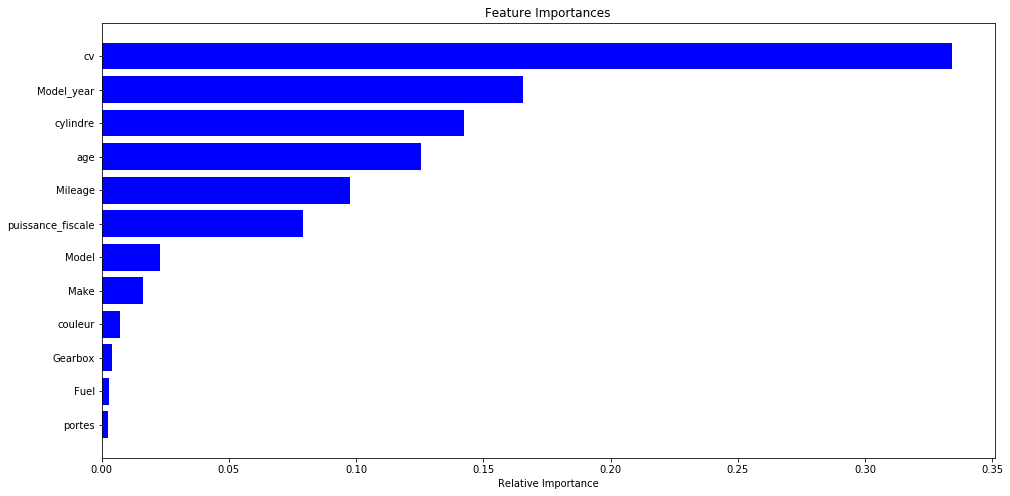

In [22]:
rfr.feature_importances_
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [24]:
#X_test_imp = imp.transform(X_test)
y_pred = rfr.predict(X_test)
print("Score du model Random Forest Regressor on train dataset: {}".format(rfr.score(X_train, y_train.values)))
print("Score du model Random Forest Regressor on test dataset: {}".format(rfr.score(X_test, y_test.values)))
print("-----"*10)
print("MSE: {:.2f}".format(mean_squared_error(y_test.values, y_pred)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test.values, y_pred))))
print("-----"*10)
print("MAE: {:.2f}".format(mean_absolute_error(y_test.values, y_pred)))
print("MAPE: {:.2f} %".format(MAPE(np.exp(y_test.values.reshape(1, -1)[0]), np.exp(y_pred)) * 100))

Score du model Random Forest Regressor on train dataset: 0.9918650720815501
Score du model Random Forest Regressor on test dataset: 0.9605249895279809
--------------------------------------------------
MSE: 0.01
RMSE: 0.12
--------------------------------------------------
MAE: 0.07
MAPE: 14.35 %


Without using hyperparameter on RandomForest Algorithme

- Using Imputer on all dataset with strategy = mean => MAPE = 0.17
- Using Linear Regression to impute missing value on cv and cylindre => MAPE = 0.14

## Using Cross Validation to see how model is variate on Training set

In [35]:
# Custom metrics for pipeline, in this case we will use MAPE metrics defined as above
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    mape = np.mean(np.abs(y_true - y_pred) / y_true)
    accuracy = 1. - mape
    return accuracy
mape_scorer = make_scorer(accuracy_score, greater_is_better=True)

In [44]:
# import module
from sklearn.model_selection import KFold

#rf_cv = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42)

scores = []
mape = []

cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                            X_train.iloc[val_index, :], \
                                            y_train.values[train_index], y_train.values[val_index]
    # model
    rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
    # metric mape
    mape.append(MAPE(np.exp(y_val.reshape(1, -1)[0]), np.exp(y_val_pred)))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=-1,
           warm_start=False)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


(0, 1)

Text(0, 0.5, 'scores')

Text(0.5, 0, 'Folder')

Text(0.5, 1.0, 'Score of Cross Validation with 10 Folder on Random Forest')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Folder')

(0, 1)

Text(0.5, 1.0, 'MAPE of Cross Validation with 10 Folder on Random Forest')

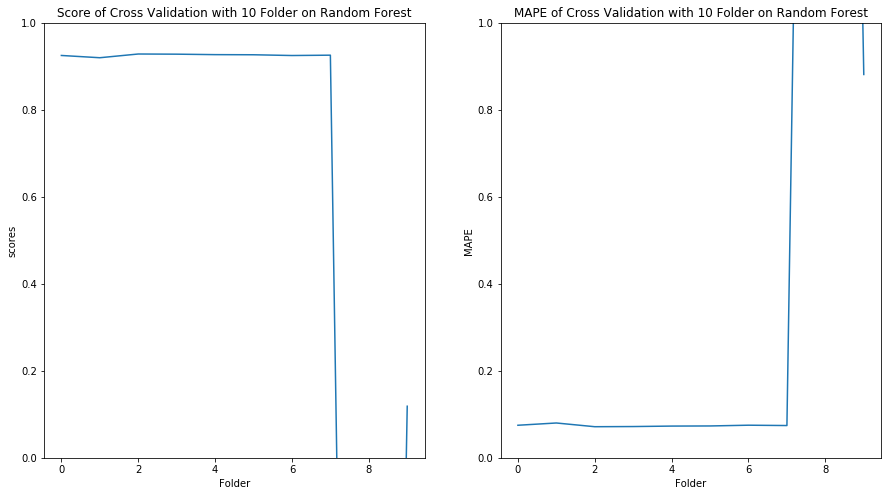

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax = ax.flatten()
ax[0].plot(range(0,10), scores)
ax[0].set_ylim([0,1])
ax[0].set_ylabel("scores")
ax[0].set_xlabel("Folder")
ax[0].set_title("Score of Cross Validation with 10 Folder on Random Forest")
ax[1].plot(range(0,10), mape)
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Folder")
ax[1].set_ylim([0,1])
ax[1].set_title("MAPE of Cross Validation with 10 Folder on Random Forest")
plt.show()

## Comparaison models with pipeline

In [46]:
%%time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from collections import defaultdict
models = [
    ("RandomForestRegressor", RandomForestRegressor()),
    ("AdaBoostRegressor", AdaBoostRegressor()),
    ("GradientBoostingRegressor", GradientBoostingRegressor()),
    ("ExtraTreesRegressor", ExtraTreesRegressor()),
    ("BaggingRegressor", BaggingRegressor())
]

scores = defaultdict(list)
mapes = defaultdict(list)

cv = KFold(n_splits=5, random_state=42, shuffle=False)

for name, model in models:
    for train_index, val_index in cv.split(X_train):

        X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                                X_train.iloc[val_index, :], \
                                                y_train.values[train_index], y_train.values[val_index]
        # model
        # rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
        # fit
        model.fit(X_train_cv, y_train_cv)
        y_val_pred = model.predict(X_val)
        # add score
        scores[name].append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
        # metric mape
        mapes[name].append(MAPE(np.exp(y_val.reshape(1, -1)[0]), np.exp(y_val_pred)))
    

CPU times: user 3min 30s, sys: 7.41 s, total: 3min 37s
Wall time: 3min 27s


Text(0.5, 0, 'Number of Fold')

Text(0, 0.5, 'Score')

(0, 1)

Text(0.5, 1.0, 'Score of Cross Validation with 10 Folder on Multiple Models')

Text(0.5, 0, 'Number of Fold')

Text(0, 0.5, 'Mape')

(0, 1)

Text(0.5, 1.0, 'Mape of Cross Validation with 10 Folder on Multiple Models')

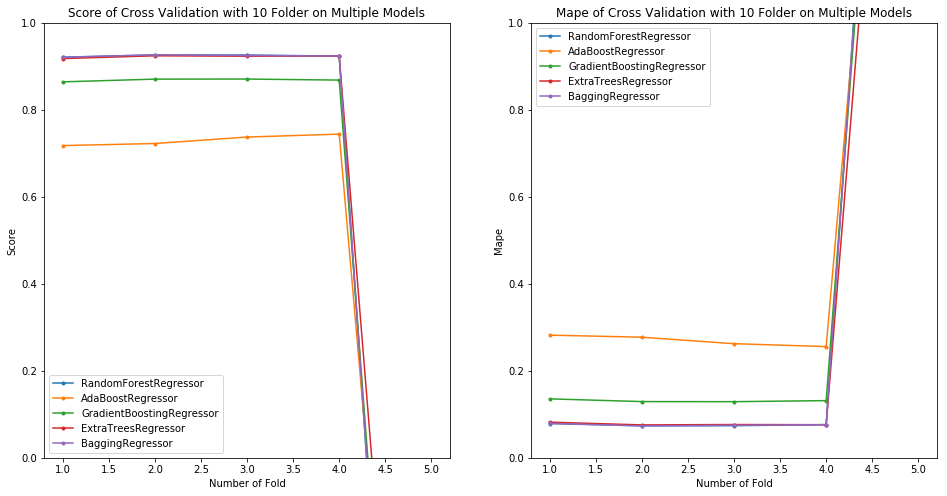

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax = ax.flatten()
ax[0].set_xlabel("Number of Fold")
ax[0].set_ylabel("Score")
ax[0].set_ylim([0,1])
ax[0].set_title("Score of Cross Validation with 10 Folder on Multiple Models")
for k, v in scores.items():
    ax[0].plot(range(1, len(v) + 1), v, '.-', label=k)
ax[0].legend()

ax[1].set_xlabel("Number of Fold")
ax[1].set_ylabel("Mape")
ax[1].set_ylim([0,1])
ax[1].set_title("Mape of Cross Validation with 10 Folder on Multiple Models")
for k, v in mapes.items():
    ax[1].plot(range(1, len(v) + 1), v, '.-', label=k)
ax[1].legend()

plt.show()

In [48]:
for i, m in mapes.items():
    print(i, m)

RandomForestRegressor [0.07874068857867039, 0.07364174202105513, 0.073852187440784, 0.07624386360749581, 3.1986077714305168]
AdaBoostRegressor [0.28205380280422154, 0.27731968400441825, 0.2624171495137977, 0.25574922922977456, 2.6904897326671415]
GradientBoostingRegressor [0.13554853954602847, 0.1292563513378724, 0.12904959299466853, 0.1314795432831682, 2.933246243481566]
ExtraTreesRegressor [0.08200739574736775, 0.07561101520482633, 0.07650806215070521, 0.07610946182634415, 2.695325431478925]
BaggingRegressor [0.07921765437728212, 0.0733249597230967, 0.0748680573616043, 0.07620207019323136, 3.166135147617162]


<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

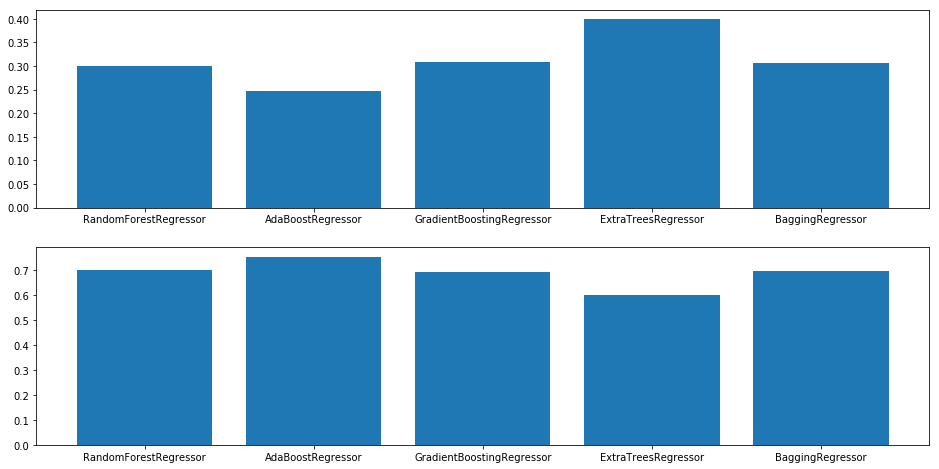

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax = ax.flatten()
for a, k in zip(ax, [scores, mapes]):
    m_k = k.keys()
    m_v = [np.mean(v) for v in k.values()]
    a.bar(m_k, m_v)
plt.show()

We choose RandomForest for our hyperparameter because it seem to have max score and min mape

## Hyperparameter with Random Forest

In [52]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [54]:
# X_train, X_test, y_train, y_test
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring=mape_scorer)
# Fit the random search model
grid_search.fit(X_train, y_train.values)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.1s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.2s
[CV] bootstr

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.7min


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  19.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  20.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  20.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=  39.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  56.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  18.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  18.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  19.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.1min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.1min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  28.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  29.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  25.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, m

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 64.5min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  21.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  21.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  43.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  46.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  29.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  28.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  22.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=  42.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=  54.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, m

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=  51.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=  51.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  16.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  16.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  57.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  58.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  57.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  16.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total= 1.0min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 146.1min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=  43.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  26.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  24.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  54.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  51.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  51.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  16.8s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.1min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  59.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  59.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, ma

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  38.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  57.0s
[CV] bootstrap=True, max_depth=100, max_f

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  42.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.6min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  44.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.6min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_f

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  41.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  43.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  42.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  41.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 258.2min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, ma

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  36.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.3min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  53.3s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  33.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  33.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  37.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  38.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  48.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  49.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  41.0s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  21.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 346.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(MAPE, greater_is_better=False), verbose=2)

In [55]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

```json
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}
```

In [52]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mape = MAPE(predictions, test_labels)
    accuracy = 100 - mape*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [60]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test.values)

Model Performance
Accuracy = 99.17%.


## Save model

In [59]:
MODEL_PATH = os.path.join(BASE_DIR, "model")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    joblib.dump(grid_search.best_estimator_, os.path.join(MODEL_PATH, 'model_rfr.pkl'))
else:
    joblib.dump(grid_search.best_estimator_, os.path.join(MODEL_PATH, 'model_rfr.pkl'))

['/Volumes/DataSu/dev/secondhand_car_price_estimation/model/model_rfr.pkl']

## Industrialization Model Machine Learning

In [53]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'n_estimators': 100
}
rf = RandomForestRegressor(**best_param_cv)
rf.fit(X_train, y_train.values)
evaluate(rf, X_test, y_test.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 99.17%.


99.17236069554123

In [54]:
df = pd.read_csv(DATA_DIR_PATH)

df.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 9 columns):
Price          166695 non-null float64
Make           166695 non-null object
Model          166695 non-null object
Model_year     166695 non-null int64
Mileage        166695 non-null object
Fuel           166695 non-null object
Gearbox        166695 non-null object
Online         166695 non-null object
Description    166695 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ MB


In [56]:
class DateOnlineEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        d_t = [datetime.strptime(c, "%d/%m/%Y à %Hh%M") for c in X.iloc[:,0].values]
        return np.array(d_t)
    
class AgeFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        d_t = [datetime.strptime(c, "%d/%m/%Y à %Hh%M") for c in X.iloc[:,0].values]
        age = [np.abs(a.year - b) for (a, b) in zip(d_t, X.iloc[:,1].values)]
        return np.array(age)

class MileageClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return np.array([float(m[0].rstrip('km').strip()) for m in X.values])
    
class DesciptionClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        def parser():
            regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
            regex_cyclindre = "\d+[\.,]\d+"
            regex_cv = "\s+\d{1,3}\s?"
            #version = []
            #puissance_fiscale = []
            #portes = []
            #options = []
            #couleur = []
            for i in range(X.shape[0]):
                match = re.search(regex_pattern, X.values[i][0])
                version = match.group(2)
                if str(version) == 'ii allurehdifap2.0150cv':
                    version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                #version.append(match.group(2))
                #puissance_fiscale.append(match.group(3))
                #portes.append(match.group(4))
                #options.append(match.group(5))
                #couleur.append(match.group(6))
                yield [cl, cv, pd.to_numeric(match.group(3)), pd.to_numeric(match.group(4)), str(match.group(6)).lower()]

        return pd.DataFrame.from_records(list(parser()))
class CategoryType(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype("object")

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [57]:
data_mapper = DataFrameMapper([
    #(["Online"], DateOnlineEncoder(), {'alias': 'Online_date_formated'}),
    (["Online", "Model_year"], AgeFeature(), {'alias': 'age'}),
    (["Make"], CategoryType()),
    (["Model"], CategoryType()),
    (["Model_year"], None),
    (["Mileage"], MileageClean()),
    (["Fuel"], CategoryType()),
    (["Gearbox"], CategoryType()),
    (["Description"], DesciptionClean()),
], input_df=True, df_out=True)

data_transform = data_mapper.fit_transform(df)

In [58]:
data_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 12 columns):
age              166695 non-null int64
Make             166695 non-null object
Model            166695 non-null object
Model_year       166695 non-null int64
Mileage          166695 non-null float64
Fuel             166695 non-null object
Gearbox          166695 non-null object
Description_0    136637 non-null float64
Description_1    159977 non-null float64
Description_2    166695 non-null int64
Description_3    165406 non-null float64
Description_4    166695 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 15.3+ MB


In [59]:
data_transform.head()

,age,Make,Model,Model_year,Mileage,Fuel,Gearbox,Description_0,Description_1,Description_2,Description_3,Description_4
0,4,PEUGEOT,308,2014,94341.0,Diesel,mécanique,1.6,92.0,4,5.0,blanc banquise
1,3,BMW,X6,2015,39051.0,Diesel,automatique,NaN,258.0,16,5.0,carbonschwarz metallise
2,4,AUDI,RS6,2014,75381.0,Essence,automatique,4.0,560.0,47,5.0,noir panthere cristal
3,11,FORD,KA,2007,92282.0,Essence,mécanique,1.3,70.0,5,3.0,jaune
4,0,FIAT,TIPO,2018,10.0,Essence,mécanique,1.4,95.0,5,5.0,blanc verni


In [60]:
ts = TypeSelector("object")
feature_category = ts.fit_transform(data_transform).head()
feature_category

,Make,Model,Fuel,Gearbox,Description_4
0,PEUGEOT,308,Diesel,mécanique,blanc banquise
1,BMW,X6,Diesel,automatique,carbonschwarz metallise
2,AUDI,RS6,Essence,automatique,noir panthere cristal
3,FORD,KA,Essence,mécanique,jaune
4,FIAT,TIPO,Essence,mécanique,blanc verni


## Pipeline

In [ ]:
preprocess_pipeline = make_pipeline(
    FeatureUnion(transformer_list=[
        ("categorical_features", make_pipeline(
            TypeSelector("object"),
            LabelEncoder(),
        ))
    ])
)

regression_pipeline = make_pipeline(
    data_mapper,
    preprocess_pipeline,
    RandomForestRegressor(**best_param_cv)
)

## Model Interpreter

In [ ]:
import shap
# Initialize JS For Plot
shap.initjs()

In [ ]:
# Explainer
explainer = shap.TreeExplainer(rfr)

In [ ]:
# calculate shap values for one point testing dataset
shap_values = explainer.shap_values(X_test_imp[0])

In [ ]:
shap_values[0]

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:15], X_test.iloc[:15,:])

In [ ]:
shap.force_plot(explainer.expected_value,shap_values[0],X_test.iloc[0,:], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
# Dependence Plot
shap.dependence_plot("age", shap_values,X_test, interaction_index="Model_year")

In [ ]:
shap.dependence_plot("age", shap_values,X_test, interaction_index="Make")

In [ ]:
shap.dependence_plot("Model_year", shap_values,X_test, interaction_index="age")